# Tensorflow on GPU

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import copy
import metpy
import metpy.calc

2024-04-16 10:15:01.479797: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 10:15:01.508565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 10:15:03.311792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


2024-04-16 10:15:07.735249: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-16 10:15:07.735304: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: wopr.nsstc.uah.edu
2024-04-16 10:15:07.735310: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: wopr.nsstc.uah.edu
2024-04-16 10:15:07.735435: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.54.3
2024-04-16 10:15:07.735457: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.54.3
2024-04-16 10:15:07.735460: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 535.54.3


In [3]:
# we will set the seed this time to ensure fairness
tf.random.set_seed(1)

In [4]:
#us_asos = pd.read_csv("/share/share/combined_asos_2023.csv")
us_asos = pd.read_csv("/rhome/sfreeman/teaching/data/combined_asos_2023.csv")

In [5]:
def nws_heat_index(T, RH):
    '''
    T in fahrenheit, RH in %
    https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml
    '''
    initial_hi =  0.5 * (T + 61.0 + ((T-68.0)*1.2) + (RH*0.094))
    if initial_hi < 80:
        return initial_hi

    adjustment_factor = 0
    if T>=80 and T<=112 and RH <13:
        adjustment_factor =  ((13-RH)/4)*np.sqrt((17-np.abs(T-95.))/17)
    
    if T>=80 and T<=87 and RH > 85:
         adjustment_factor = ((RH-85)/10) * ((87-T)/5)

    return (-42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - 
           .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH) + adjustment_factor

nws_heat_index_vectorized = np.vectorize(nws_heat_index)

In [6]:
us_asos['relh_raw'] = metpy.calc.relative_humidity_from_dewpoint(us_asos['tmpf'].values*metpy.units.units("degF"), 
                                                             us_asos['dwpf'].values*metpy.units.units("degF")).magnitude*100

In [7]:
us_asos['relh_raw'] 

0          103.602431
1          103.618159
2          103.633990
3          103.633990
4          107.416554
              ...    
6782526     70.192226
6782527     73.059775
6782528     73.059775
6782529     75.936726
6782530     82.150664
Name: relh_raw, Length: 6782531, dtype: float64

In [8]:
us_asos['relh'] = us_asos['relh_raw'].clip(0,100)

In [9]:
us_asos['heat_index'] = nws_heat_index_vectorized(us_asos["tmpf"], us_asos['relh'])

/nas/rhome/sfreeman/mambaforge/envs/tensorflow_gpu/lib/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in nws_heat_index (vectorized)
  outputs = ufunc(*inputs)


<Axes: >

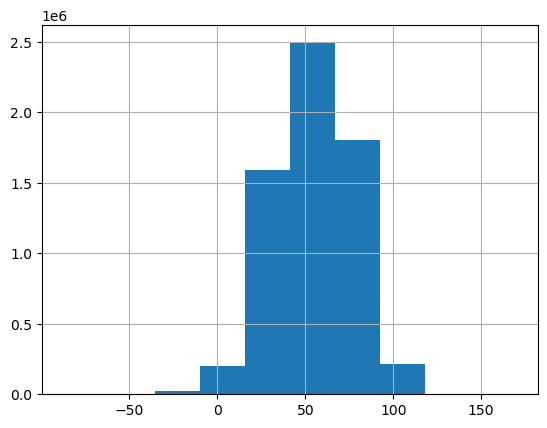

In [10]:
us_asos['heat_index'].hist()

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
us_asos_nona = us_asos.dropna(subset=['tmpf', 'relh', 'heat_index'])

In [13]:
# Prepare our data first

training_data_US, test_validation_US = train_test_split(us_asos_nona, test_size=0.25)
testing_data_US, validation_data_US = train_test_split(test_validation_US, test_size=0.5)

In [14]:
tf.keras.backend.clear_session()

input1 = keras.layers.Input(shape=(2, ))
input_norm = keras.layers.Normalization(axis=1)(input1)


dense1 = keras.layers.Dense(256, activation=None)(input_norm)
lerelu_layer = keras.layers.LeakyReLU(alpha=0.3)(dense1) 
dense2 = keras.layers.Dense(128,  activation=keras.activations.relu)(lerelu_layer)
dense3 = keras.layers.Dense(128,  activation=keras.activations.relu)(dense2)

output = keras.layers.Dense(1, activation=None, use_bias=True)(dense3)
model_US = keras.models.Model(inputs=[input1], outputs=[output])
model_US.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')
model_US.summary()

/nas/rhome/sfreeman/mambaforge/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,310 (196.53 KB)

 Trainable params: 50,305 (196.50 KB)

 Non-trainable params: 5 (24.00 B)

In [15]:
%%time
model_US.fit(training_data_US[['tmpf', 'relh']].values, 
           training_data_US['heat_index'].values, epochs=5, batch_size=1024, shuffle=True )

Epoch 1/5
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 27.1344
Epoch 2/5
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 1.3733
Epoch 3/5
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.3760
Epoch 4/5
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.5160
Epoch 5/5
4640/4640 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1680
CPU times: user 10min 27s, sys: 50 s, total: 11min 17s
Wall time: 1min 8s
